C:\Users\Janith\AppData\Local\Temp\ipykernel_38728\2446768529.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\Janith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6147 - val_loss: 0.5068
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5057 - val_loss: 0.3555
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3362 - val_loss: 0.3586
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2537 - val_loss: 0.2789
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2195 - val_loss: 0.2747
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2251 - val_loss: 0.2708
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2079 - val_loss: 0.2674
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2220 - val_loss: 0.2642
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2762 - val_loss: 0.2632
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2332 - val_loss: 0.2697
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2265 - val_loss: 0.2732
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

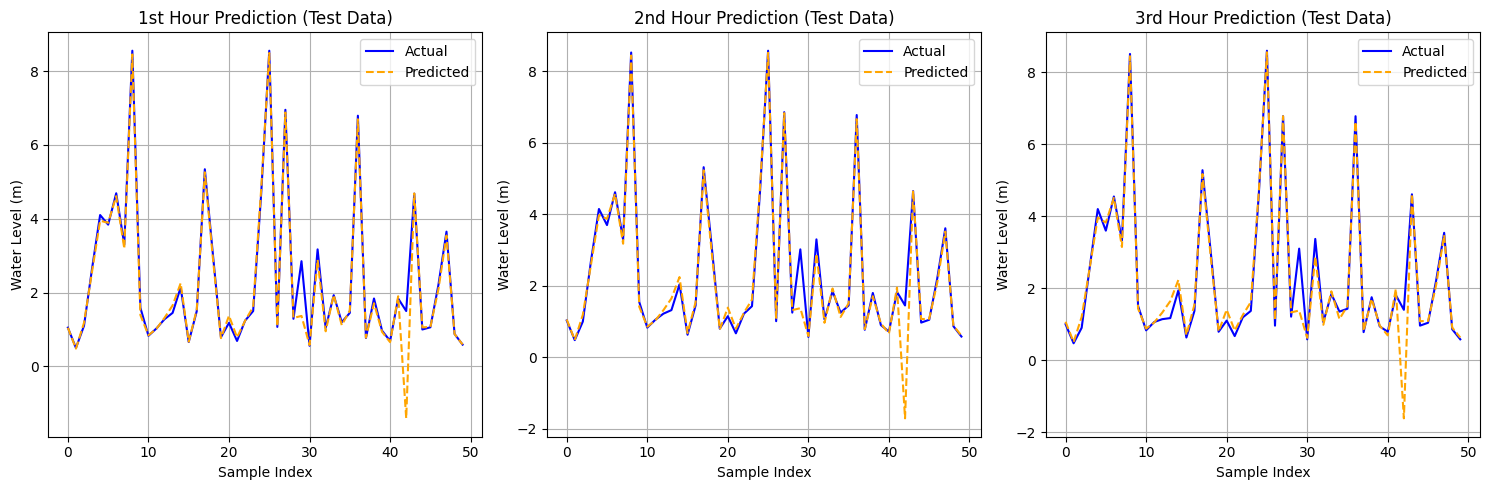

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Function to create time-step sequences
def create_time_steps_data(X, y, time_steps):
    """
    Converts 2D data into 3D format for LSTM (samples, time_steps, features).
    
    Args:
        X: Input features (2D array).
        y: Target values (2D array).
        time_steps: Number of time steps to include in each sample.
        
    Returns:
        X_new: 3D array for LSTM (samples, time_steps, features).
        y_new: Target values (aligned with time steps).
    """
    X_new, y_new = [], []
    
    for i in range(time_steps, len(X)):
        # Use the past `time_steps` rows as input
        X_new.append(X[i-time_steps:i, :])
        # Align the target with the last time step
        y_new.append(y[i])
    
    return np.array(X_new), np.array(y_new)

# Set number of time steps
time_steps = 3

# Convert data into time-step format
X_time_steps, y_time_steps = create_time_steps_data(X_scaled, y, time_steps)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_time_steps, y_time_steps, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the LSTM model
model = Sequential()

# LSTM layers
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3))  # 3 outputs (1st, 2nd, 3rd hour predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Visualize true vs predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Janith\AppData\Local\Temp\ipykernel_45500\2540506494.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)



Testing Results:
1st Hour Prediction Accuracy: 96.00%, MAE: 0.0782
2nd Hour Prediction Accuracy: 92.70%, MAE: 0.1440
3rd Hour Prediction Accuracy: 89.52%, MAE: 0.2010


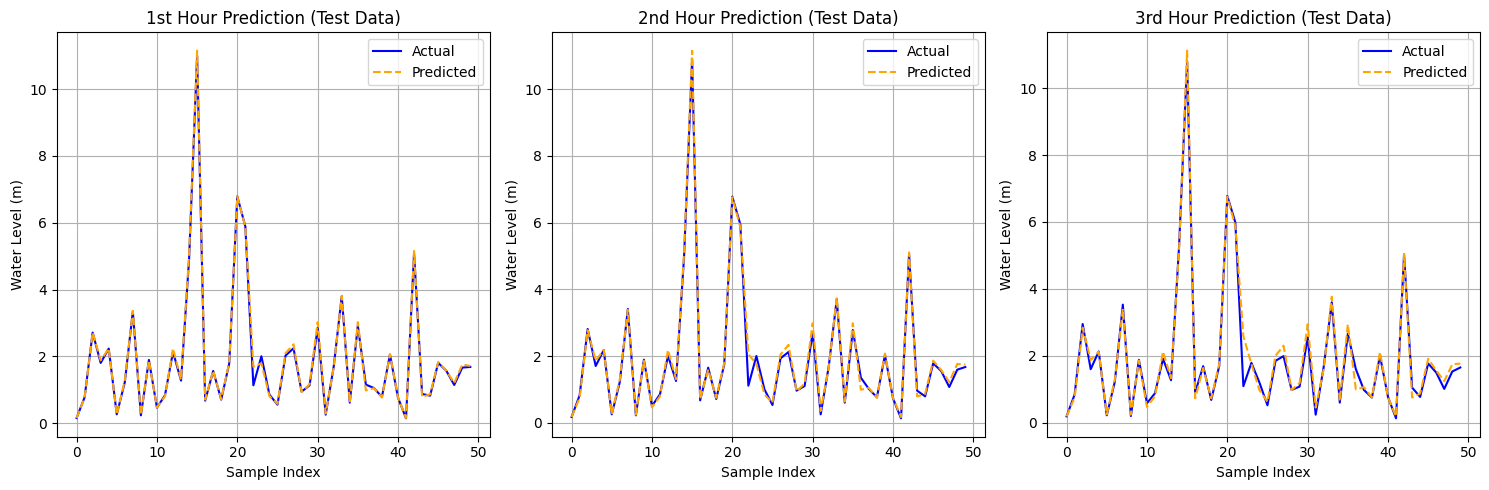

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize Gradient Boosting Regressors for each target variable
gbr_1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the models
gbr_1.fit(X_train, y_train[:, 0])
gbr_2.fit(X_train, y_train[:, 1])
gbr_3.fit(X_train, y_train[:, 2])

# Predict on the test set
y_test_pred_1 = gbr_1.predict(X_test)
y_test_pred_2 = gbr_2.predict(X_test)
y_test_pred_3 = gbr_3.predict(X_test)
y_test_pred = np.column_stack([y_test_pred_1, y_test_pred_2, y_test_pred_3])

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Visualize true vs predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Janith\AppData\Local\Temp\ipykernel_45500\1015502592.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)



Testing Results:
1st Hour Prediction Accuracy: 95.57%, MAE: 0.0823
2nd Hour Prediction Accuracy: 92.00%, MAE: 0.1478
3rd Hour Prediction Accuracy: 88.45%, MAE: 0.2030

Sample Test Predictions:
Index | Actual 1st Hour | Predicted 1st Hour | Actual 2nd Hour | Predicted 2nd Hour | Actual 3rd Hour | Predicted 3rd Hour
0     | 1.1500          | 1.1441             | 1.1000          | 1.1455             | 1.0700          | 1.1794            
1     | 0.5300          | 0.5804             | 0.5200          | 0.6174             | 0.5100          | 0.6424            
2     | 1.2500          | 1.2123             | 1.2000          | 1.2150             | 1.1500          | 1.2291            
3     | 2.5500          | 2.4885             | 2.6000          | 2.4498             | 2.6300          | 2.3864            
4     | 3.4000          | 3.0239             | 3.7000          | 2.9978             | 3.9000          | 2.9657            
5     | 3.7800          | 3.8099             | 3.8600          | 3.7

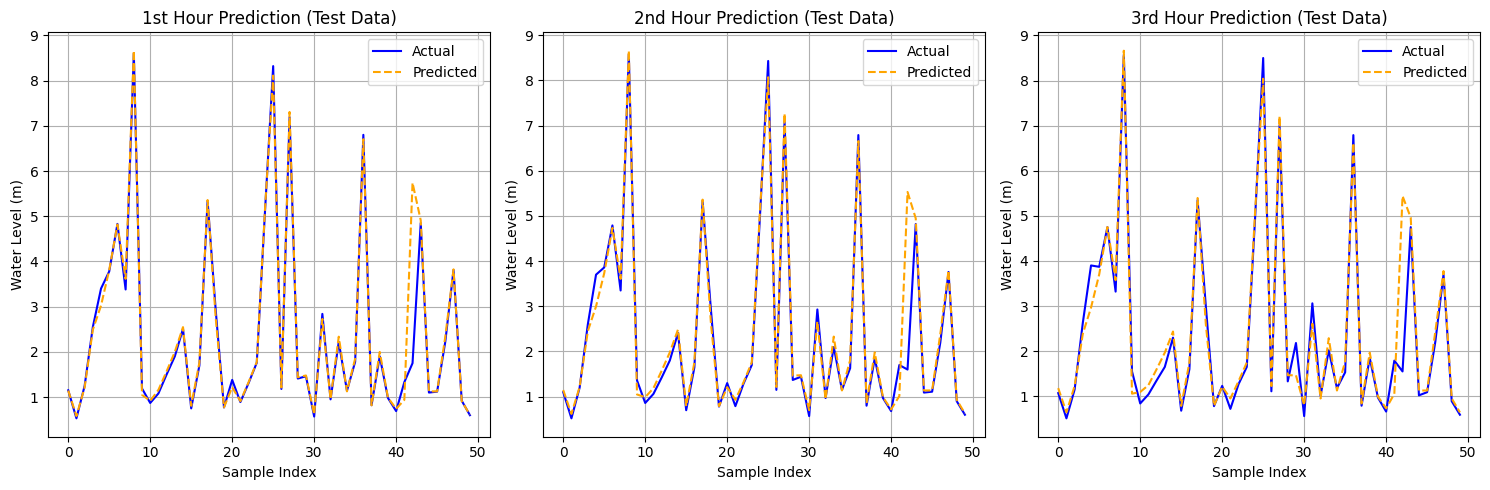

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Create target columns for the next 1, 2, and 3-hour water levels
data['Next 1 Hour Water Level (m)'] = data['Water Level (m)'].shift(-1)
data['Next 2 Hours Water Level (m)'] = data['Water Level (m)'].shift(-2)
data['Next 3 Hours Water Level (m)'] = data['Water Level (m)'].shift(-3)

# Drop rows with NaN values after shifting
data.dropna(inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize Gradient Boosting Regressors for each target variable
gbr_1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the models
gbr_1.fit(X_train, y_train[:, 0])
gbr_2.fit(X_train, y_train[:, 1])
gbr_3.fit(X_train, y_train[:, 2])

# Predict on the test set
y_test_pred_1 = gbr_1.predict(X_test)
y_test_pred_2 = gbr_2.predict(X_test)
y_test_pred_3 = gbr_3.predict(X_test)
y_test_pred = np.column_stack([y_test_pred_1, y_test_pred_2, y_test_pred_3])

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Print 10 test samples with actual and predicted values
print("\nSample Test Predictions:")
print("Index | Actual 1st Hour | Predicted 1st Hour | Actual 2nd Hour | Predicted 2nd Hour | Actual 3rd Hour | Predicted 3rd Hour")
for i in range(10):
    print(f"{i:<5} | {y_test[i, 0]:<15.4f} | {y_test_pred[i, 0]:<18.4f} | {y_test[i, 1]:<15.4f} | {y_test_pred[i, 1]:<18.4f} | {y_test[i, 2]:<15.4f} | {y_test_pred[i, 2]:<18.4f}")

# Visualize true vs predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data - Copy.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Create target columns for the next 1, 2, and 3-hour water levels
data['Next 1 Hour Water Level (m)'] = data['Water Level (m)'].shift(-1)
data['Next 2 Hours Water Level (m)'] = data['Water Level (m)'].shift(-2)
data['Next 3 Hours Water Level (m)'] = data['Water Level (m)'].shift(-3)

# Drop rows with NaN values after shifting
data.dropna(inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input and output data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Reshape input for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[1])),
    LSTM(50, activation='relu'),
    Dense(3)
])


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Inverse transform predictions to original scale
y_test_pred = scaler_y.inverse_transform(y_test_pred)
y_test = scaler_y.inverse_transform(y_test)



Epoch 1/50


C:\Users\Janith\AppData\Local\Temp\ipykernel_45500\1726737513.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\Janith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0596 - val_loss: 0.0168
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0032
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 8.4754e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3648e-04 - val_loss: 7.4502e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9280e-04 - val_loss: 7.3184e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0415e-04 - val_loss: 7.6089e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2332e-04 - val_loss: 7.1051e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3574e-04 - val_loss: 7.1105e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3623e-04 - val_loss: 7.0663e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2682e-04 - val_loss: 7.5014e-04
Epo


Testing Results:
1st Hour Prediction Accuracy: 94.61%, MAE: 0.0939
2nd Hour Prediction Accuracy: 92.79%, MAE: 0.1391
3rd Hour Prediction Accuracy: 90.62%, MAE: 0.1893

Sample Test Predictions:
Index | Actual 1st Hour | Predicted 1st Hour | Actual 2nd Hour | Predicted 2nd Hour | Actual 3rd Hour | Predicted 3rd Hour
0     | 1.1500          | 1.1351             | 1.1000          | 1.1367             | 1.0700          | 1.1378            
1     | 0.5300          | 0.5132             | 0.5200          | 0.5144             | 0.5100          | 0.4921            
2     | 1.2500          | 1.1540             | 1.2000          | 1.1554             | 1.1500          | 1.1559            
3     | 2.5500          | 2.3652             | 2.6000          | 2.3552             | 2.6300          | 2.3198            
4     | 3.4000          | 2.9174             | 3.7000          | 2.9025             | 3.9000          | 2.8523            
5     | 3.7800          | 3.5773             | 3.8600          | 3.5

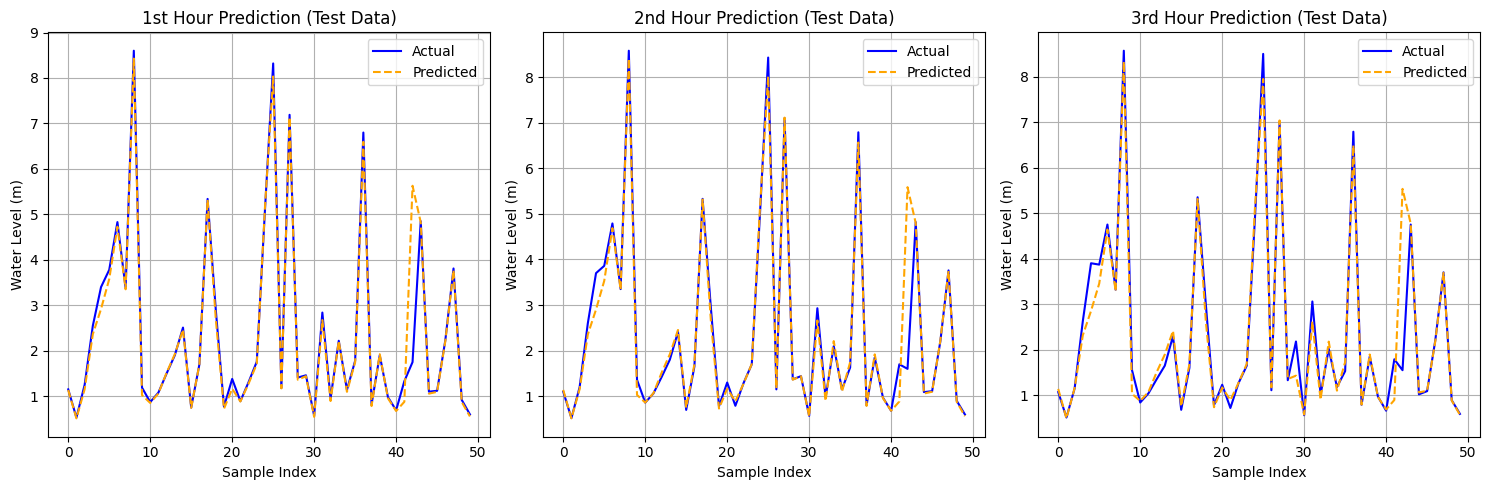

In [13]:
# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Print 10 test samples with actual and predicted values
print("\nSample Test Predictions:")
print("Index | Actual 1st Hour | Predicted 1st Hour | Actual 2nd Hour | Predicted 2nd Hour | Actual 3rd Hour | Predicted 3rd Hour")
for i in range(10):
    print(f"{i:<5} | {y_test[i, 0]:<15.4f} | {y_test_pred[i, 0]:<18.4f} | {y_test[i, 1]:<15.4f} | {y_test_pred[i, 1]:<18.4f} | {y_test[i, 2]:<15.4f} | {y_test_pred[i, 2]:<18.4f}")

# Visualize true vs predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


Missing values in each column before processing:
Date                              0
Hour                              0
Discharge Rate (cumecs)          11
Rainfall Data (mm)              122
Water Level (m)                  23
Next 1 Hour Water Level (m)      28
Next 2 Hours Water Level (m)     33
Next 3 Hours Water Level (m)     38
dtype: int64
Missing values in each column after processing:
Date                            0
Hour                            0
Discharge Rate (cumecs)         0
Rainfall Data (mm)              0
Water Level (m)                 0
Next 1 Hour Water Level (m)     0
Next 2 Hours Water Level (m)    0
Next 3 Hours Water Level (m)    0
dtype: int64
Training set size: 3612
Validation set size: 774
Testing set size: 774


C:\Users\Janith\AppData\Local\Temp\ipykernel_18028\292755270.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)



Testing Results:
1st Hour Prediction Accuracy: 95.99%, MAE: 0.0823
2nd Hour Prediction Accuracy: 92.63%, MAE: 0.1547
3rd Hour Prediction Accuracy: 89.48%, MAE: 0.2184

Sample Predictions vs Actual Values:
   Actual 1st Hour  Predicted 1st Hour  Actual 2nd Hour  Predicted 2nd Hour  \
0             0.15            0.129957             0.17            0.133381   
1             0.77            0.768790             0.82            0.781510   
2             2.71            2.705375             2.81            2.742000   
3             1.80            1.900043             1.70            1.910890   
4             2.23            2.305231             2.18            2.290156   
5             0.26            0.258782             0.25            0.265775   
6             1.22            1.208855             1.22            1.194723   
7             3.34            3.363900             3.41            3.417817   
8             0.23            0.237903             0.22            0.232733   
9   

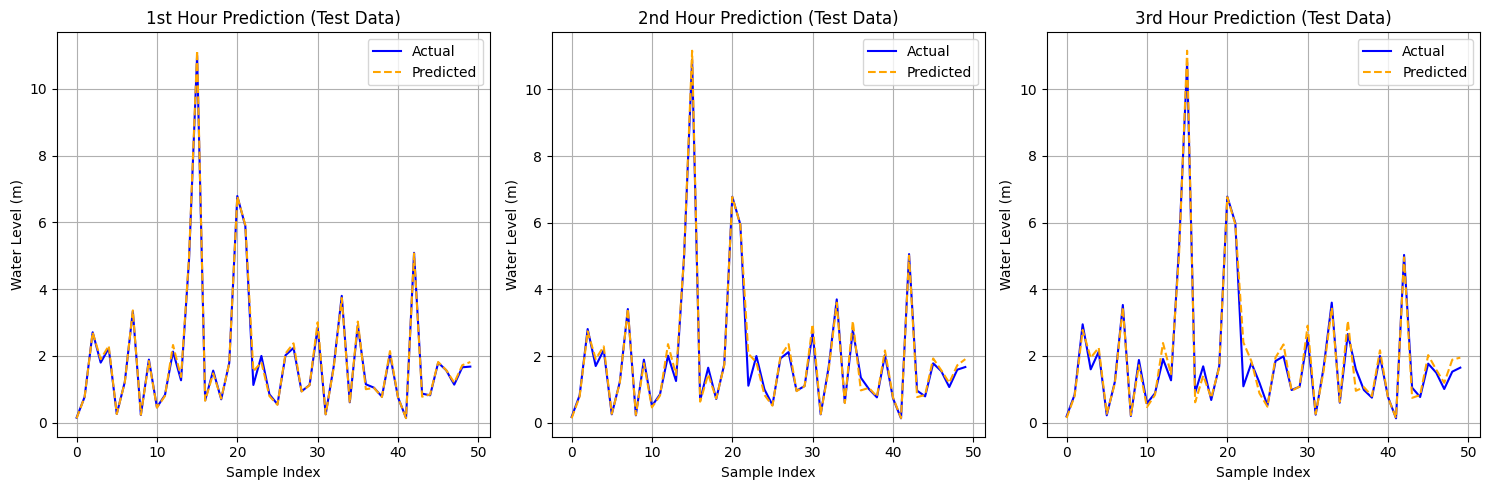

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Check for null values
print("Missing values in each column before processing:")
print(data.isnull().sum())

# Method 1: Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Method 2: Interpolation (optional, if you want to interpolate instead of forward fill)
#data.interpolate(method='linear', inplace=True)

# Recheck for null values after filling
print("Missing values in each column after processing:")
print(data.isnull().sum())

# Drop 'Date' and 'Hour' columns
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42) #100 trees are created.
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

## Calculate accuracy for each hour
#accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
#accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
#accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
#
## Print accuracies
#print("\nTesting Accuracy:")
#print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%")
#print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%")
#print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%")

# Display some sample predictions vs actual values
print("\nSample Predictions vs Actual Values:")
sample_data = pd.DataFrame({
    'Actual 1st Hour': y_test[:, 0],
    'Predicted 1st Hour': y_test_pred[:, 0],
    'Actual 2nd Hour': y_test[:, 1],
    'Predicted 2nd Hour': y_test_pred[:, 1],
    'Actual 3rd Hour': y_test[:, 2],
    'Predicted 3rd Hour': y_test_pred[:, 2],
})
print(sample_data.head(10))

# Visualization: True vs Predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


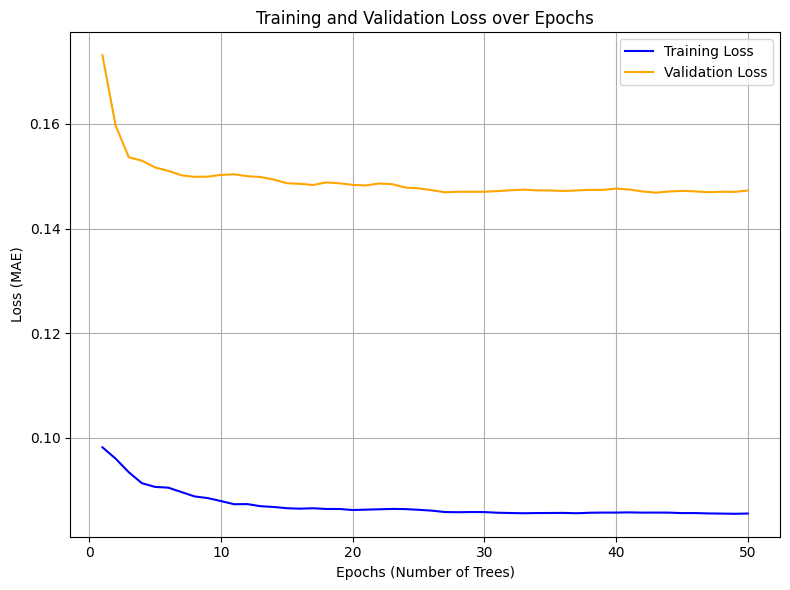

In [6]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Use warm_start to incrementally train the model
model = RandomForestRegressor(n_estimators=100, warm_start=True, random_state=42)

train_losses = []
val_losses = []

n_trees = 50  # Number of 'epochs' or tree additions
for i in range(1, n_trees + 1):
    model.set_params(n_estimators=i)
    model.fit(X_train, y_train)

    # Predict on training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calculate MAE
    train_loss = mean_absolute_error(y_train, y_train_pred)
    val_loss = mean_absolute_error(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_trees + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, n_trees + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs (Number of Trees)')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Reshape the data to be 3D for LSTM input
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D shape for LSTM (number of rows,time steps,number of input features)
print(X_scaled.shape)
# # Split dataset into training (70%), validation (15%), and testing (15%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Initialize the LSTM model
# model = Sequential()

[[[0.01572519 0.         0.06689835]]

 [[0.01595921 0.         0.06776716]]

 [[0.0161945  0.         0.06863597]]

 ...

 [[0.46751286 0.         0.65682016]]

 [[0.46422899 0.         0.65421373]]

 [[0.45986508 0.         0.65073849]]]


C:\Users\Janith\AppData\Local\Temp\ipykernel_13176\981187431.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
